# Исследование базы данных сервиса Stackoverflow

В этом исследовании работа идёт с базой данных StackOverflow — сервиса вопросов и ответов о программировании.  

StackOverflow похож на социальную сеть — пользователи сервиса задают вопросы, отвечают на посты, оставляют комментарии и ставят оценки другим ответам.  

**Задачи:** сформировать требуемые выгрузки данных с помощью SQL, посчитать различные продуктовые метрики и визуализировать их.

## Импортируем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с будем работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Проверим подключене

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

In [6]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', creation_date) AS month_dt,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE DATE_TRUNC('year', creation_date) IN ('2008-01-01')
GROUP BY month_dt
ORDER BY total_views DESC;
'''

df = pd.read_sql_query(query, con=engine)# выполните запрос
df

,month_dt,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Данные просмотров постов в каждый месяц отличаются.  
В июле просмотров в сотни раз меньше, чем в остальные месяцы. Можно предположить, либо в июле было опубликовано мало постов, либо платформа не работала, либо есть ошибки в сборе данных.  

Пик просмотров был в сентябре. Затем вплоть до декабря снижался.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

Какие аномалии наблюдаются в данных? О чём они говорят?

In [7]:
# напишите запрос
query = '''
SELECT u.display_name,
       COUNT(DISTINCT p.user_id)
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON u.id = p.user_id
JOIN stackoverflow.post_types pt ON p.post_type_id= pt.id
WHERE type = 'Answer'
  AND DATE_TRUNC('day', u.creation_date) + INTERVAL '1 month' >= DATE_TRUNC('day', p.creation_date)
GROUP BY u.display_name
HAVING COUNT(p.id) > 100
ORDER BY u.display_name;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)# выполните запрос
df

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


Есть пользователи с одинаковыми именами.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

In [8]:
# напишите запрос
query = '''
WITH us AS(
SELECT DISTINCT u.id
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON p.user_id = u.id
WHERE DATE_TRUNC('month', p.creation_date) = '2008-12-01'
  AND DATE_TRUNC('month', u.creation_date) = '2008-09-01')
SELECT DATE_TRUNC('month', creation_date) AS month_dt,
       COUNT(*)
FROM stackoverflow.posts P
JOIN us ON p.user_id = us.id
WHERE user_id IN(us.id)
GROUP BY month_dt
ORDER BY month_dt DESC;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,month_dt,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Мы смотрели пользователей, которые зарегистрировались в сентябре, и при этом у них оказались опубликованные посты в августе.  
Значит сбор данных был произведен не корректно.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [9]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date) AS cum_count
FROM stackoverflow.posts
ORDER BY 1,2;

'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,user_id,creation_date,views_count,cum_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

In [10]:
# напишите запрос

query = '''
WITH us AS
(SELECT user_id,
        DATE_TRUNC('day', creation_date) AS day,
        COUNT(id) AS cnt_post
FROM stackoverflow.posts
WHERE user_id IN (SELECT user_id
                  FROM stackoverflow.posts
                  WHERE DATE_TRUNC('month', creation_date) = '2008-08-01'
                  GROUP BY 1
                  HAVING COUNT(id) > 120)
    AND DATE_TRUNC('month', creation_date) = '2008-08-01'
GROUP BY 1,2)
SELECT user_id,
       AVG(cnt_post)
FROM us
GROUP BY 1;
'''
# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,user_id,avg
0,116,4.777778
1,234,5.208333
2,383,7.277778
3,905,7.000000
4,91,5.681818


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

Проанализируйте итоговую таблицу — какие выводы можно сделать?

In [11]:
# напишите запрос
query = '''
WITH day AS
(SELECT user_id,
       COUNT(DISTINCT DATE_TRUNC('day',creation_date)) AS cnt_day
FROM stackoverflow.posts
WHERE DATE_TRUNC('day', creation_date) BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY user_id)

SELECT ROUND(AVG(cnt_day))::int AS result
FROM day;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,result
0,2


В среднем пользователи взаимодействовали с платформой 2 дня в период с 1 по 7 декабря.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

In [12]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       CASE EXTRACT('month' FROM 
       LAG(creation_date,2) OVER(PARTITION BY user_id ORDER BY creation_date))
          WHEN 1 THEN 'January'
          WHEN 2 THEN 'February'
          WHEN 3 THEN 'March'
          WHEN 4 THEN 'April'
          WHEN 5 THEN 'May'
          WHEN 6 THEN 'June'
          WHEN 7 THEN 'July'
          WHEN 8 THEN 'August'
          WHEN 9 THEN 'September'
          WHEN 10 THEN 'October'
          WHEN 11 THEN 'November'
          WHEN 12 THEN 'December'
       END AS second_last_month
FROM stackoverflow.posts;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

In [13]:
# напишите запрос
query = '''
WITH first_post AS
(SELECT DISTINCT user_id,
        FIRST_VALUE(DATE_TRUNC('month', creation_date)) OVER(PARTITION BY user_id ORDER BY creation_date) AS cohort_dt
FROM stackoverflow.posts),

profile AS
(SELECT *,
        COUNT(*) OVER(PARTITION BY cohort_dt) AS cohort_users_cnt
FROM first_post),

session AS
(SELECT DISTINCT user_id,
       DATE_TRUNC('month', creation_date) AS session_date
FROM stackoverflow.posts)

SELECT p.cohort_dt,
       s.session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) *100 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN session s ON p.user_id = s.user_id
GROUP BY 1,2,4
ORDER BY 1,2;
'''

# выполните запрос WITN profile AS
df = pd.read_sql_query(query, con=engine)
df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.0
1,2008-07-01,2008-08-01,2,3,66.0
2,2008-07-01,2008-09-01,1,3,33.0
3,2008-07-01,2008-10-01,2,3,66.0
4,2008-07-01,2008-11-01,1,3,33.0
5,2008-07-01,2008-12-01,2,3,66.0
6,2008-08-01,2008-08-01,2151,2151,100.0
7,2008-08-01,2008-09-01,1571,2151,73.0
8,2008-08-01,2008-10-01,1275,2151,59.0
9,2008-08-01,2008-11-01,1050,2151,48.0


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

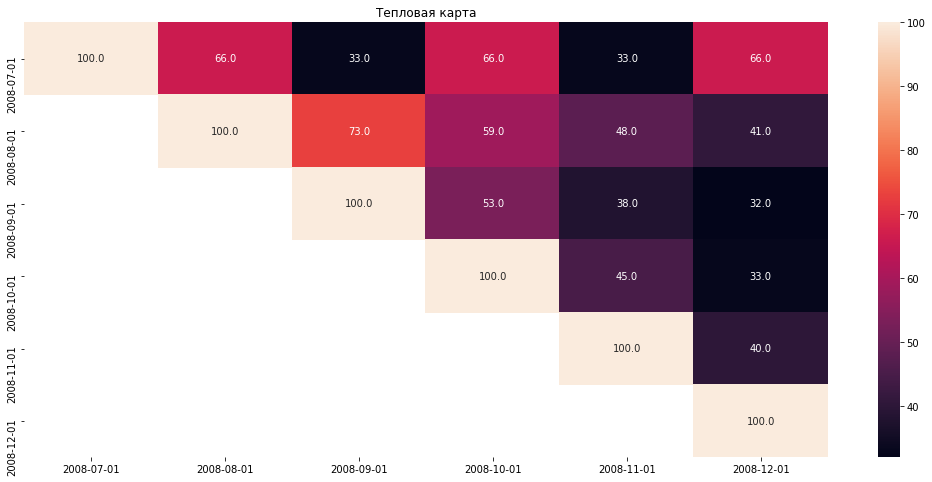

In [14]:
# постройте тепловую карту Retention Rate
retention = df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(18, 8)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

Коэффециент удержания в норме постепенно должен снижаться.  
У когорты от июля месяца показатели скачут. Количество пользователей в данной когорте крайне мало - 3 чел.  

Так же можно отметить снижение коэффециента удержания от когорте к когорте.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

In [18]:
# напишите запрос
query = '''
SELECT EXTRACT(MONTH FROM creation_date)::INT AS creation_month,
       COUNT(id) AS posts_count,
       ROUND((COUNT(id)::numeric / LAG(COUNT(id)) OVER(ORDER BY EXTRACT(MONTH FROM creation_date)::INT) -1)* 100, 2) AS percentage
FROM stackoverflow.posts
WHERE DATE_TRUNC('DAY', creation_date) BETWEEN '2008-09-01' AND '2008-12-31'
GROUP BY creation_month;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

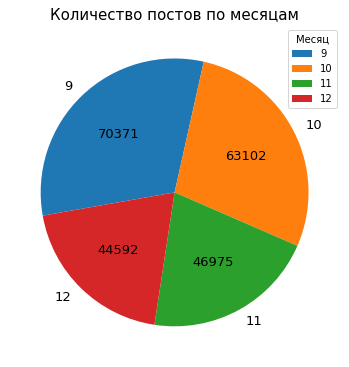

In [16]:
values=df['posts_count']
ax = df.plot(kind='pie', y='posts_count',
             figsize=(6,9),
             labels=df['creation_month'],
             autopct= lambda x: '{:.0f}'.format(x*values.sum()/100),
             textprops = {"fontsize":13},
             startangle=190,counterclock=False)

plt.title('Количество постов по месяцам',fontsize=15)
ax.set_ylabel('')
plt.legend(title = "Месяц")
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [17]:
# напишите запрос
query = '''
WITH user_top AS 
(SELECT user_id,
       COUNT(id)
FROM stackoverflow.posts
GROUP BY 1
ORDER BY 2 DESC
LIMIT 1),

user_post AS
(SELECT p.user_id,
       EXTRACT(WEEK FROM p.creation_date) AS week_creation,
       p.creation_date
FROM stackoverflow.posts p
JOIN user_top u ON u.user_id = p.user_id
WHERE DATE_TRUNC('month', p.creation_date) = '2008-10-01')

SELECT DISTINCT week_creation,
       MAX(creation_date) OVER(PARTITION BY week_creation) AS creation_date
FROM user_post
ORDER BY 1;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,week_creation,creation_date
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
